# Курсовая работа
## по курсу "Фундаментальные концепции искусственного интеллекта"

### Выполнил студент группы М8О-114СВ-24 Мальцев Иван

Dataset: [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

Выбранный датасет применяется для решения задачи поиска опухоли головного мозга по его МРТ снимку.
В датасет входит около 500 МРТ снимков, разделённых на 2 класса ('yes' - снимки с опухолью, 'no' - снимки без опухоли). Снимки представлены в форматах JPG, JPEG и PNG.


In [130]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from typing import List, Tuple
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go

Создадим класс для датасета

In [131]:
class BrainTumorDataset(Dataset):
    def __init__(self, dir: str, transform=None):
        self.dir = Path(dir)
        self.transform = transform
        self.valid_extensions = ('.jpg', '.jpeg', '.png', '.JPG')
        self.data: List[Tuple[str, int]] = []
        self.class_counts = {'yes': 0, 'no': 0}
        self.load_dataset()

    def load_dataset(self):
        tumor_dir = self.dir / 'yes'
        for ext in self.valid_extensions:
            tumor_images = list(tumor_dir.glob(f'*{ext}'))
            for img_path in tumor_images:
                self.data.append((str(img_path), 1))
                self.class_counts['yes'] += 1

        no_tumor_dir = self.dir / 'no'
        for ext in self.valid_extensions:
            no_tumor_images = list(no_tumor_dir.glob(f'*{ext}'))
            for img_path in no_tumor_images:
                self.data.append((str(img_path), 0))
                self.class_counts['no'] += 1
        
        self.data = np.array(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        labels = int(label) 
        if self.transform:
            image = self.transform(image)
    
        return image, labels

Теперь создадим объект класса и посмотрим на его элементы

Tumor


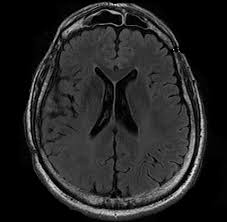

In [132]:
ds = BrainTumorDataset(dir="C:/Users/ivanm/Downloads/brain_tumor_dataset")
print('Tumor' if ds.data[350][1] else 'No Tumor')
Image.open(ds.data[350][0]).convert('RGB')

Получим точную статистику по датасету

In [133]:
print(f"Dataset loaded successfully:")
print(f"Total images: {len(ds.data)}")
print(f"Tumor images: {ds.class_counts['yes']} ({(ds.class_counts['yes']/len(ds.data)*100):.2f}%)")
print(f"Non-tumor images: {ds.class_counts['no']} ({(ds.class_counts['no']/len(ds.data)*100):.2f}%)")

Dataset loaded successfully:
Total images: 498
Tumor images: 309 (62.05%)
Non-tumor images: 189 (37.95%)


Статистика наглядно

In [134]:
fig = px.bar(x=["with_tumor", "without_tumor"], y=[ds.class_counts['yes'], ds.class_counts['no']])
fig.show()

In [135]:
labels = ['With tumor', 'Without tumor']
values = [ds.class_counts['yes'], ds.class_counts['no']]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

### Обучение модели
Создадим класс модели

In [136]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(TumorClassifier, self).__init__()
        self.mri_classifier = models.resnet50(pretrained=True)

        for param in list(self.mri_classifier.parameters())[:-6]:
            param.requires_grad = False

        num_features = self.mri_classifier.fc.in_features
        self.mri_classifier.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.mri_classifier(x)

Зададим необходимые трансформации для изображений

In [137]:
temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = BrainTumorDataset(dir="C:/Users/ivanm/Downloads/brain_tumor_dataset", transform=temp_transform)
loader = DataLoader(dataset, batch_size=32, num_workers=0)

all_pixels = []

for img, _ in loader:
    all_pixels.append(img.numpy())

In [138]:
mri_means = np.mean(all_pixels[0][0][0][0])
mri_stds = np.std(all_pixels[0][0][0][0])

In [139]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mri_means, std=mri_stds)
])

Теперь зададим параметры обучения

In [144]:
device = torch.device('cpu')
mri_data = BrainTumorDataset(dir="C:/Users/ivanm/Downloads/brain_tumor_dataset", transform=transform)

total_size = len(mri_data)

train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(mri_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
#test_loader = DataLoader(test_dataset, batch_size=32)

model = TumorClassifier().to(device)

original_dataset = train_dataset.dataset
train_indices = [train_dataset.indices[i] for i in range(len(train_dataset))]
train_labels = [int(original_dataset.data[idx][1]) for idx in train_indices]

num_pos = sum(train_labels)
num_neg = len(train_labels) - num_pos
pos_weight = torch.tensor([num_neg / num_pos]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5, verbose=True
)

history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'best_model': None,
        'best_epoch': 0,
        'best_val_loss': float('inf')
    }

num_epochs = 10

c:\Users\ivanm\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



И запустим обучение

In [145]:
for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            
            inputs, labels = inputs.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
            
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    

Epoch 1/10:
Train Loss: 0.5165, Train Acc: 0.4070
Val Loss: 0.4849, Val Acc: 0.3600
Epoch 2/10:
Train Loss: 0.4139, Train Acc: 0.5930
Val Loss: 0.3115, Val Acc: 0.6900
Epoch 3/10:
Train Loss: 0.3033, Train Acc: 0.7940
Val Loss: 0.2030, Val Acc: 0.8700
Epoch 4/10:
Train Loss: 0.2569, Train Acc: 0.8166
Val Loss: 0.1922, Val Acc: 0.9200
Epoch 5/10:
Train Loss: 0.1749, Train Acc: 0.9146
Val Loss: 0.1275, Val Acc: 0.9400
Epoch 6/10:
Train Loss: 0.1574, Train Acc: 0.9221
Val Loss: 0.1004, Val Acc: 0.9300
Epoch 7/10:
Train Loss: 0.1849, Train Acc: 0.9095
Val Loss: 0.1121, Val Acc: 0.9300
Epoch 8/10:
Train Loss: 0.1043, Train Acc: 0.9322
Val Loss: 0.0672, Val Acc: 0.9800
Epoch 9/10:
Train Loss: 0.0749, Train Acc: 0.9673
Val Loss: 0.0572, Val Acc: 0.9600
Epoch 10/10:
Train Loss: 0.0766, Train Acc: 0.9623
Val Loss: 0.0441, Val Acc: 1.0000


Посмотрим на графики обучения

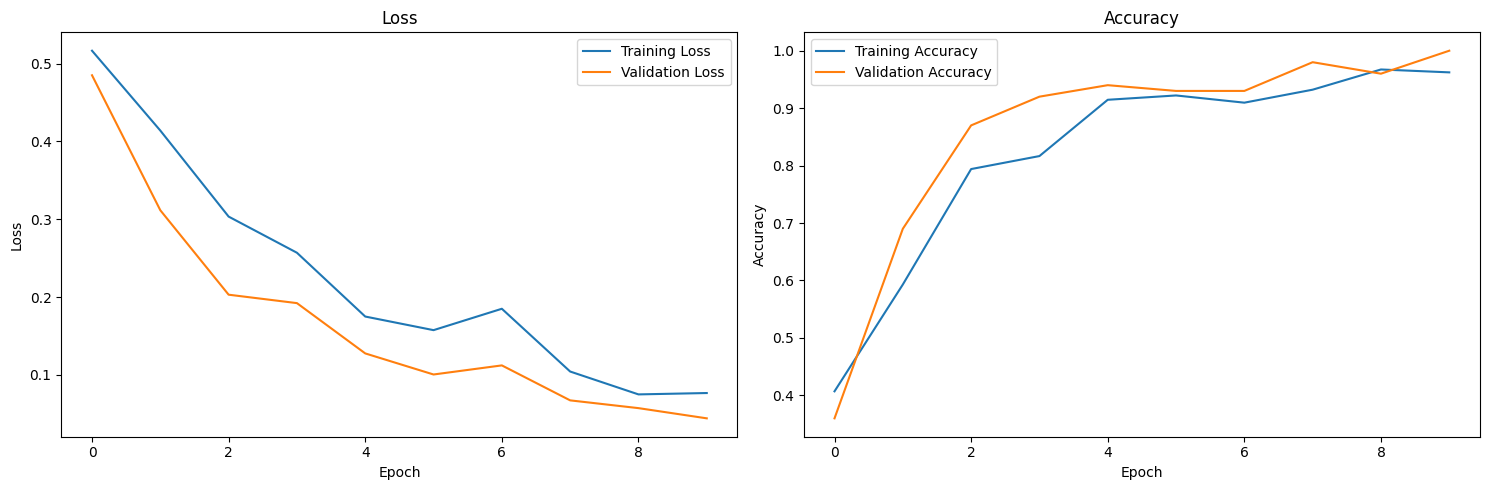

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy plot
ax2.plot(history['train_acc'], label='Training Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()

Проверим работу обученной модели на скачанных из интернета фотографиях

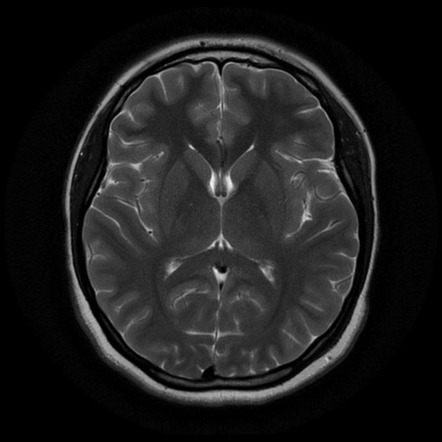

In [147]:
model.eval()

img = Image.open('C:/Users/ivanm/Downloads/brain_mri_1.jpeg').convert('RGB')
tr_img = transform(img)
output = model(tr_img.unsqueeze(0))
img

In [148]:
pred = (output > 0.5).float()
print('Tumor' if pred[0][0] else 'No Tumor')

No Tumor


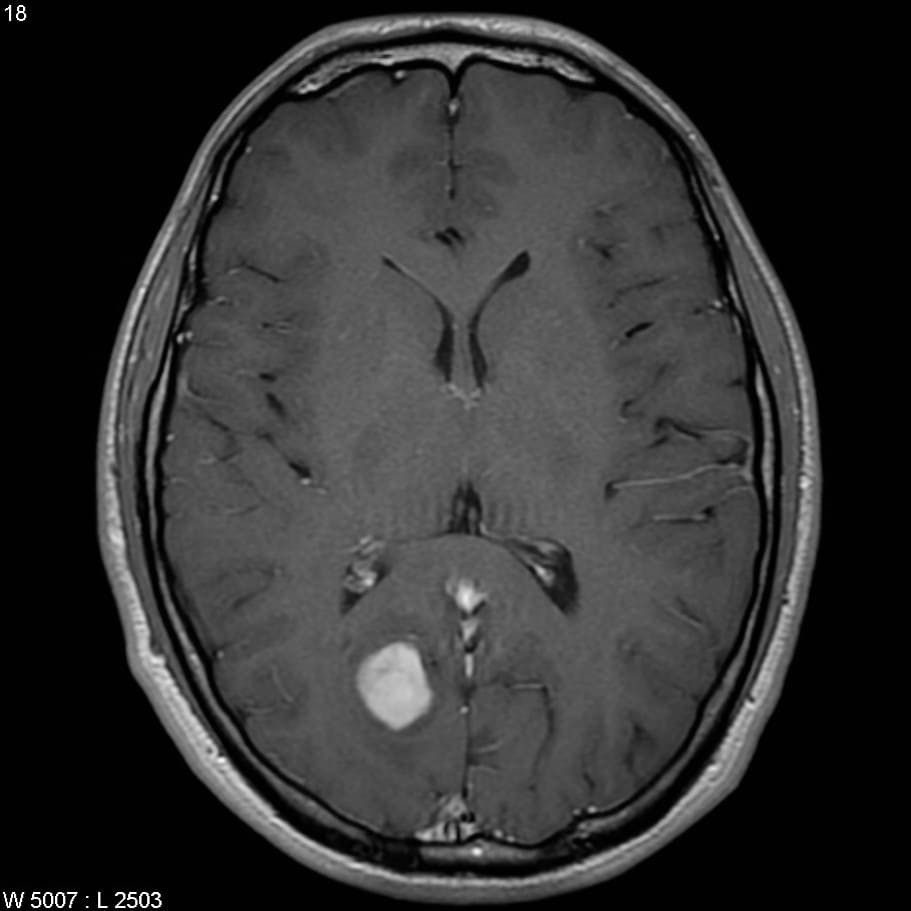

In [149]:
img = Image.open('C:/Users/ivanm/Downloads/brain_mri_2.jpg').convert('RGB')
tr_img = transform(img)
output = model(tr_img.unsqueeze(0))
img

In [150]:
pred = (output > 0.5).float()
print('Tumor' if pred[0][0] else 'No Tumor')

Tumor


### Понижение размерности
Применим Principal component analysis (PCA) для понижения размерности

In [151]:
from sklearn.decomposition import PCA

mri_data = BrainTumorDataset(dir="C:/Users/ivanm/Downloads/brain_tumor_dataset", transform=transform)
mri_data_array = np.array([np.ravel(sample[0]) for sample in mri_data])


pca = PCA(n_components=3)
reduced_data = pca.fit_transform(mri_data_array)

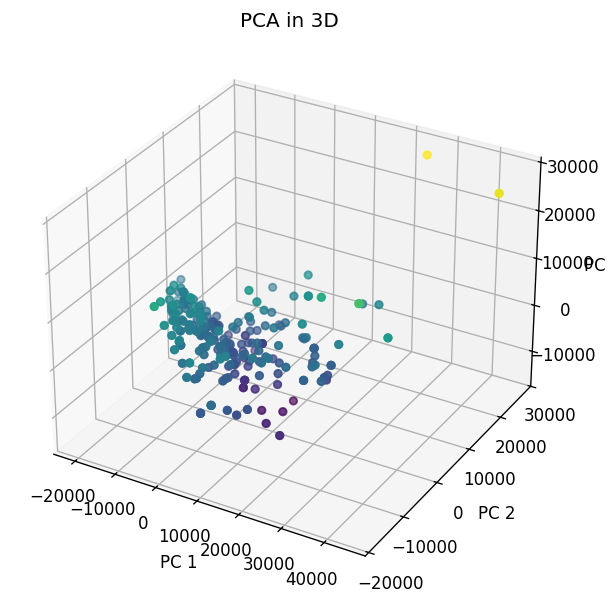

In [152]:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(projection='3d')

ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=reduced_data[:, 2])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('PCA in 3D')

plt.show()

### Кластеризация
Для кластеризации используем метод KMeans

In [91]:
from sklearn.cluster import KMeans

In [153]:
X = reduced_data

In [154]:
kmeans = KMeans(n_clusters=2, max_iter=300)
kmeans.fit(X)

c:\Users\ivanm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=2)

In [155]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

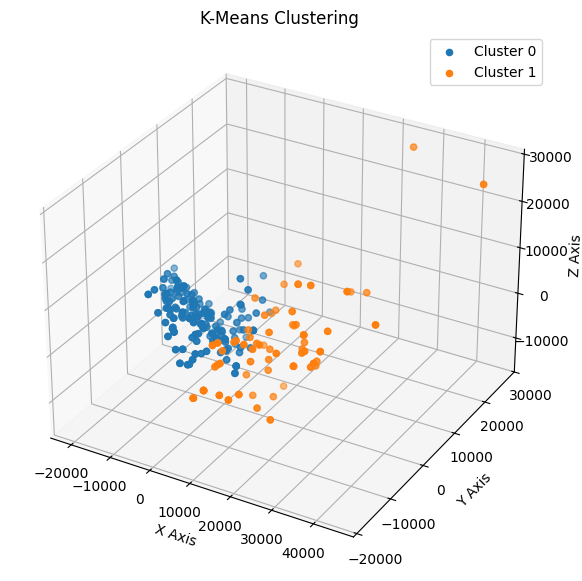

In [156]:
# Визуализация 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Отображение точек, цвет определяется меткой кластера
for cluster in range(2):
    cluster_points = [X[i] for i in range(len(labels)) if labels[i] == cluster]
    cluster_points = np.array(cluster_points)
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f"Cluster {cluster}")

ax.set_title("K-Means Clustering")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.legend()
plt.show()


### ML system design
На основе датасета можно построить ML-систему для автоматической диагностики опухолей мозга по снимкам МРТ. Такая система предназначена для помощи врачам в ускорении анализа снимков и снижении вероятности пропуска опухоли. В качестве модели в системе могут быть выбраны такие популярные свёрточные сети, как ResNet, VGG, YOLO и т.д.

Подобная ML-система может быть полезна в следующих областях:
1. Клиническа система диагностики
2. Телемедицина
3. Научные исследования

Такая ML-система имеет ряд преимуществ, среди которых снижение нагрузки на врачей и выявление редких случаев. Но чтобы система была действительно рабочей и обладала высокой точностью нужен большой объём сбалансированных данных. Представленный в работе датасет небольшой и имеет дисбаланс в данных, из-за чего не может использоваться в продакшн решениях. Он больше подходит для учебных задач.